# CIFAR10 90% test accuracy
This notebook is a (hopefully cleaner) reimplementation of a [kaggle notebook](https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min).  
The first goal is to familiarize my self with more advanced architecture and training method than the baseline tutorial model.  
The second goal is to interpret the trained model.  

## Setup

### Imports

In [1]:
from collections.abc import Sequence

import torch
from torch import Tensor
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from torch.nn import CrossEntropyLoss
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
)

from models import ResNet9
from trainer import Trainer
from data_loaders import MyDataLoader as DL
from adversarial_attacks import ProjectedGradientDescent as PGD

# mp.set_start_method('spawn', force=True)

### Search for an accelerator

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Model definition

In [3]:
model = ResNet9(3, 10).cuda()
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Datasets, Transforms and Data loaders

### Transforms

In [4]:
CHANNELS_MEAN = (0.4914, 0.4822, 0.4465)
CHANNELS_STD = (0.2023, 0.1994, 0.2010)

training_transform = Compose([
    RandomCrop(32, padding=4, padding_mode="constant"),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(CHANNELS_MEAN, CHANNELS_STD, inplace=True),
])
attacker = PGD(10, 4/255, CrossEntropyLoss(), model, 50/255)

validation_transform = Compose([ToTensor(), Normalize(CHANNELS_MEAN, CHANNELS_STD)])

### Datasets

In [5]:
training_dataset = CIFAR10(root="./datasets/cifar10/", train=True, download=True, transform=training_transform)
validation_dataset = CIFAR10(root="./datasets/cifar10/", train=False, transform=validation_transform)

Files already downloaded and verified


### Datasets loaders

In [6]:
BATCH_SIZE = 400

training_dl = DL(training_dataset, BATCH_SIZE, shuffle=True, num_workers=3, device=device, pin_memory=True, attacker=attacker)
validation_dl = DL(validation_dataset, BATCH_SIZE * 2, num_workers=3, device=device, pin_memory=True, attacker=attacker)

### Dataset visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


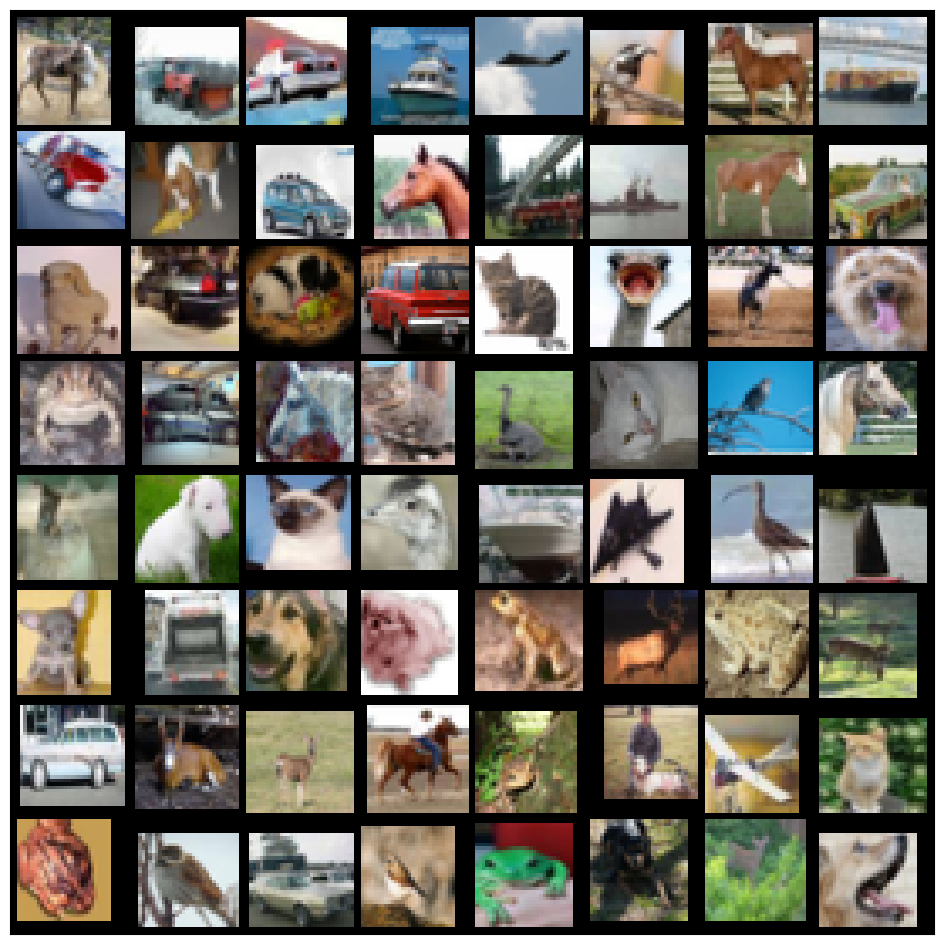

In [7]:
base_imgs, labels = next(iter(training_dl))
images, labels = base_imgs.cpu(), labels.cpu()
as_tensor = lambda stats: Tensor(stats).view(1, 3, 1, 1)
unormalize_imgs =  lambda imgs: imgs * as_tensor(CHANNELS_STD) + as_tensor(CHANNELS_MEAN)
images = unormalize_imgs(images)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))

In [ ]:
EPOCHS = 24
MAX_LR = 0.02
optimizer = Adam(model.parameters(), MAX_LR, weight_decay=1e-4)
lr_scheduler = OneCycleLR(optimizer, MAX_LR, epochs=EPOCHS, steps_per_epoch=len(training_dl))
trainer = Trainer(
    model,
    optimizer,
    lr_scheduler = lr_scheduler,
)

In [9]:
training_metrics = trainer.optimize_nn(
    epochs=EPOCHS,
    train_dl=training_dl,
    test_dl=validation_dl,
    plt_kwargs=dict(x="epoch", y=["train_loss", "train_accuracy", "test_loss", "test_accuracy"], height=600),
).set_index("epoch")

FigureWidget({
    'data': [{'hovertemplate': 'variable=train_loss<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_loss',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '0d72e3a2-b40a-4d7a-a26e-5050856f18fe',
              'x': array([0]),
              'xaxis': 'x4',
              'y': array([2.34988215]),
              'yaxis': 'y4'},
             {'hovertemplate': 'variable=train_accuracy<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_accuracy',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_accuracy',
              'orientation': 'v',
   

time to train on V100: 48 mins

In [10]:
! mkdir -p "models"
torch.save(model.state_dict(), "./models/" + model.name + ".pth")

In [11]:
training_metrics

,step,date,test_loss,test_accuracy,train_loss,train_accuracy,lr,betas,eps,weight_decay,...,foreach,capturable,differentiable,fused,initial_lr,max_lr,min_lr,max_momentum,base_momentum,params
epoch,,,,,,,,,,,,,,,,,,,,,
0,0,2025-06-03 16:26:10.216304,2.351903,0.05300,2.349882,0.05448,4.000000e-04,"(0.95, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,125,2025-06-03 16:28:09.327096,1.704008,0.36615,1.920279,0.30395,8.507077e-04,"(0.9453051280635585, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,250,2025-06-03 16:30:07.555694,1.586839,0.42060,1.705950,0.37292,2.118190e-03,"(0.9321021851542174, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,375,2025-06-03 16:32:05.799942,1.619774,0.41950,1.618116,0.41073,3.964421e-03,"(0.9128706163177169, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,500,2025-06-03 16:34:03.963588,1.650422,0.41830,1.557482,0.43693,6.042687e-03,"(0.8912220116670262, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,625,2025-06-03 16:36:02.191036,1.470227,0.45700,1.497897,0.45893,7.962701e-03,"(0.8712218682596511, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,750,2025-06-03 16:38:00.295706,1.465815,0.46845,1.419006,0.49127,9.363893e-03,"(0.8566261105759152, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
7,875,2025-06-03 16:39:58.357045,1.410113,0.49385,1.363039,0.51025,9.983128e-03,"(0.8501757471414374, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
8,1000,2025-06-03 16:41:56.421104,1.391361,0.50795,1.315885,0.52893,9.943034e-03,"(0.8505696623452367, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
